<h1><font size=12>
Weather Derivatites </h1>
<h1> Rainfall Simulator -- Full modeling <br></h1>

Developed by [Jesus Solano](mailto:ja.solano588@uniandes.edu.co) <br>  
16 September 2018 


In [1]:
# Import needed libraries. 
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from scipy.stats import gamma
import pickle
import time
import datetime

# Generate artificial Data

In [2]:
### ENSO probabilistic forecast.

# Open saved data.
ensoForecast = pickle.load(open('../datasets/ensoForecastProb/ensoForecastProbabilities.pickle','rb'))

# Print an example .. ( Format needed)

ensoForecast['2005-01']

,Season,La Niña,Neutral,El Niño
0,JFM 2005,0%,15%,85%
1,FMA 2005,0%,17%,83%
2,MAM 2005,1%,24%,75%
3,AMJ 2005,2%,43%,55%
4,MJJ 2005,4%,51%,45%
5,JJA 2005,6%,54%,40%
6,JAS 2005,8%,52%,40%
7,ASO 2005,9%,51%,40%
8,SON 2005,10%,50%,40%
9,OND 2005,10%,50%,40%


In [3]:
### Create total dataframe.

def createTotalDataFrame(daysNumber, startDate , initialState , initialPrep , ensoForecast ):
    # Set variables names.
    totalDataframeColumns = ['state','Prep','Month','probNina','probNino', 'nextState']

    # Create dataframe.

    allDataDataframe = pd.DataFrame(columns=totalDataframeColumns) 

    # Number of simulation days(i.e 30, 60)
    daysNumber = daysNumber

    # Simulation start date ('1995-04-22')
    startDate = startDate

    # State of rainfall last day before start date --> Remember 0 means dry and 1 means wet.
    initialState = initialState
    initialPrep = initialPrep   # Only fill when initialState == 1  


    dates = pd.date_range(startDate, periods = daysNumber + 2 , freq='D')

    for date in dates: 

        # Fill precipitation amount.
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'Prep'] = np.nan

        # Fill month of date 
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'Month'] = date.month

        # Fill El Nino ENSO forecast probability. 
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'probNino'] = float(ensoForecast[date.strftime('%Y-%m')].loc[0,'El Niño'].strip('%').strip('~'))/100

        # Fill La Nina ENSO forecast probability. 
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'probNina'] = float(ensoForecast[date.strftime('%Y-%m')].loc[0,'La Niña'].strip('%').strip('~'))/100

        # Fill State. 
        allDataDataframe.loc[date.strftime('%Y-%m-%d'),'state'] = np.nan


    simulationDataFrame = allDataDataframe[:-1]

    # Fill initial conditions. 
    simulationDataFrame['state'][0] = initialState
    if initialState == 1:
        simulationDataFrame['Prep'][0] = initialPrep
    else:
        simulationDataFrame['Prep'][0] = 0.0
    
    return simulationDataFrame

simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-08-18', initialState = 1 , initialPrep =  0.4, ensoForecast = ensoForecast)
simulationDataFrame.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,state,Prep,Month,probNina,probNino,nextState
2017-08-18,1,0.4,8,0.09,0.09,NaN
2017-08-19,NaN,NaN,8,0.09,0.09,NaN
2017-08-20,NaN,NaN,8,0.09,0.09,NaN
2017-08-21,NaN,NaN,8,0.09,0.09,NaN
2017-08-22,NaN,NaN,8,0.09,0.09,NaN


In [4]:
### Load transitions and amount parameters.

# Transitions probabilites.
transitionsParametersDry = pd.read_csv('../results/visibleMarkov/transitionsParametersDry.csv', sep = ' ', header=None, names = ['variable', 'value'])
transitionsParametersDry.index += 1 
transitionsParametersDry

transitionsParametersWet = pd.read_csv('../results/visibleMarkov/transitionsParametersWet.csv', sep = ' ', header=None, names = ['variable', 'value'])
transitionsParametersWet.index += 1 
transitionsParametersWet

#amountParametersGamma = pd.read_csv('../results/visibleMarkov/amountGammaPro.csv', sep = ' ', header=None, names = ['variable', 'mu', 'shape'])
#amountParametersGamma.index += 1 
# !!!!!! Delete !!!!!!!!!!!!!11. 
amountParametersGamma = pd.read_csv('../results/visibleMarkov/fittedGamma.csv', index_col=0)

print(transitionsParametersDry)

print('\n * Intercept means firts month (January) ')


       variable     value
1   (Intercept) -1.168017
2        Month2  0.346713
3        Month3  0.848934
4        Month4  1.563185
5        Month5  1.567584
6        Month6  1.132592
7        Month7  1.311161
8        Month8  1.432857
9        Month9  0.924944
10      Month10  1.587704
11      Month11  1.356612
12      Month12  0.518480
13     probNino -0.453497
14     probNina  0.176919

 * Intercept means firts month (January) 


## Simulation Function Core

In [5]:
### Build the simulation core.

# Updates the state of the day based on yesterday state. 
def updateState(yesterdayIndex, simulationDataFrame, transitionsParametersDry, transitionsParametersWet):
    
    # Additional data of day.
    yesterdayState = simulationDataFrame['state'][yesterdayIndex]
    yesterdayPrep = simulationDataFrame['Prep'][yesterdayIndex]
    yesterdayProbNino = simulationDataFrame['probNino'][yesterdayIndex]
    yesterdayProbNina = simulationDataFrame['probNina'][yesterdayIndex]
    yesterdayMonth = simulationDataFrame['Month'][yesterdayIndex]
    
    # Calculate transition probability.
    if yesterdayState == 0:
        
        # Includes month factor + probNino value + probNino value.
        successProbabilityLogit = transitionsParametersDry['value'][yesterdayMonth] + yesterdayProbNino*transitionsParametersDry['value'][13] +  yesterdayProbNina*transitionsParametersDry['value'][14]
        successProbability = (np.exp(successProbabilityLogit))/(1+np.exp(successProbabilityLogit))
    elif yesterdayState == 1:
        
        # Includes month factor + probNino value + probNino value + prep value .
        successProbabilityLogit = transitionsParametersDry['value'][yesterdayMonth] + yesterdayProbNino*transitionsParametersWet['value'][14] +  yesterdayProbNina*transitionsParametersWet['value'][15] + yesterdayPrep*transitionsParametersWet['value'][13] 
        successProbability = (np.exp(successProbabilityLogit))/(1+np.exp(successProbabilityLogit))
    else:
        print('State of date: ', simulationDataFrame.index[yesterdayIndex],' not found.')
    
    #print(successProbability)
    #successProbability = monthTransitions['p'+str(yesterdayState)+'1'][yesterdayMonth] 
    
    todayState = bernoulli.rvs(successProbability)
    
    return todayState 

In [6]:
# Simulates one run of simulation. 
def oneRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma):
    
    # Define the total rainfall amount over the simulation.
    rainfall = 0
    
    # Total rainfall days.
    wetDays = 0
    
    # Loop over days in simulation to calculate rainfall ammount.
    for day in range(1,len(simulationDataFrame)):
        
        # Get today date. 
        dateOfDay = datetime.datetime.strptime(simulationDataFrame.index[day],'%Y-%m-%d')
       
    
        # Update today state based on the yesterday state. 
        todayState = updateState(day-1, simulationDataFrame, transitionsParametersDry, transitionsParametersWet)
        
        # Write new day information.
        simulationDataFrame['state'][day] = todayState
        simulationDataFrame['nextState'][day-1] = todayState
        
        # Computes total accumulated rainfall.
        if todayState == 1:
            
            # Sum wet day.
            wetDays+=1
            
            # Additional data of day.
            todayProbNino = simulationDataFrame['probNino'][day]
            todayProbNina = simulationDataFrame['probNina'][day]
            todayMonth = simulationDataFrame['Month'][day]
            
            
            '''
            
            # Calculates gamma log(mu).
            gammaLogMu = amountParametersGamma['mu'][todayMonth]+ todayProbNino*amountParametersGamma['mu'][13]+todayProbNino*amountParametersGamma['mu'][13] 
            #print(gammaMu)
            # Calculates gamma scale
            gammaLogShape = amountParametersGamma['shape'][todayMonth]+ todayProbNino*amountParametersGamma['shape'][13]+todayProbNino*amountParametersGamma['shape'][13]
            #print(gammaShape)
            
            # Update mu
            gammaMu = np.exp(gammaLogMu)
            
            # Update shape
            gammaShape = np.exp(gammaLogShape)
            
            # Calculate gamma scale.
            gammaScale = gammaMu / gammaShape
            
            # Generate random rainfall.
            todayRainfall = gamma.rvs(a = gammaShape, scale = gammaScale)
            
            '''
            
            # !!!!!! Delete !!!!!!!!!!!!!11. 
            todayRainfall = gamma.rvs(amountParametersGamma['Shape'][0],amountParametersGamma['Loc'][0],amountParametersGamma['Scale'][0]) 
            
            
            
            # Write new day information.
            simulationDataFrame['Prep'][day] = todayRainfall
            
            # Updates rainfall amount. 
            rainfall += todayRainfall
            
        else:
            # Write new day information.
            simulationDataFrame['Prep'][day] = 0
            
        
        yesterdayState = todayState
            
    
    return rainfall,wetDays

In [7]:
updateState(0, simulationDataFrame, transitionsParametersDry, transitionsParametersWet)

1

In [8]:
# Run only one iteration(Print structure of results)

# Simulations iterations.
iterations = 10000

oneRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma)


(73.314447511956, 27)

## Complete Simulation

In [9]:
# Run total iterations.
def totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations):
    
    # Initialize time 
    startTime = time.time()
    
    # Array to store all precipitations.
    rainfallPerIteration = [None]*iterations
    
    wetDaysPerIteration = [None]*iterations
    
    # Loop over each iteration(simulation)
    
    for i in range(iterations):
        
        simulationDataFrameC = simulationDataFrame.copy()
        
        iterationRainfall,wetDays = oneRun(simulationDataFrameC, transitionsParametersDry, transitionsParametersWet, amountParametersGamma)
        
        rainfallPerIteration[i] = iterationRainfall
        
        wetDaysPerIteration[i] = wetDays
    
    # Calculate time
    currentTime = time.time() - startTime 
    
    # Print mean of wet days. 
    
    print('The mean of wet days is: ', np.mean(wetDaysPerIteration))
    
    # Logging time.
    print('The elapsed time over simulation is: ', currentTime, ' seconds.')
    
    return rainfallPerIteration

In [10]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-12-18', initialState = 1 , initialPrep =  0.4, ensoForecast = ensoForecast)
simulationDataFrame.head()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


,state,Prep,Month,probNina,probNino,nextState
2017-12-18,1,0.4,12,0.83,0,NaN
2017-12-19,NaN,NaN,12,0.83,0,NaN
2017-12-20,NaN,NaN,12,0.83,0,NaN
2017-12-21,NaN,NaN,12,0.83,0,NaN
2017-12-22,NaN,NaN,12,0.83,0,NaN


## Final Results

In [11]:
# Final Analysis.

finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)


The mean of wet days is:  15.524
The elapsed time over simulation is:  26.80415964126587  seconds.


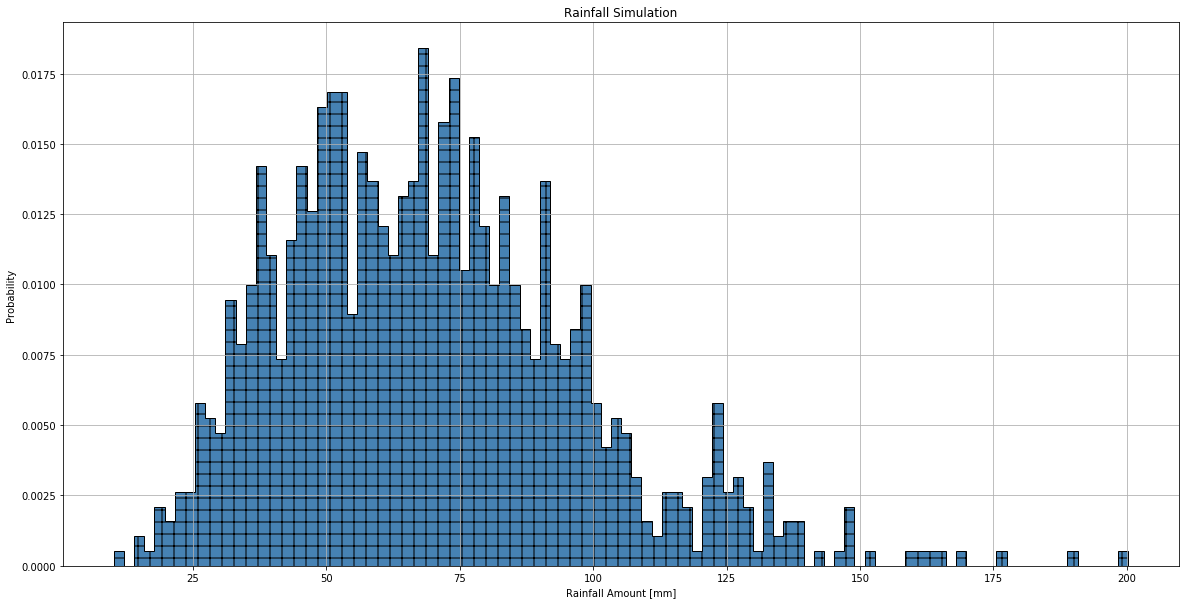

In [12]:
fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='steelblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

### Enero 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  7.555
The elapsed time over simulation is:  24.961527585983276  seconds.


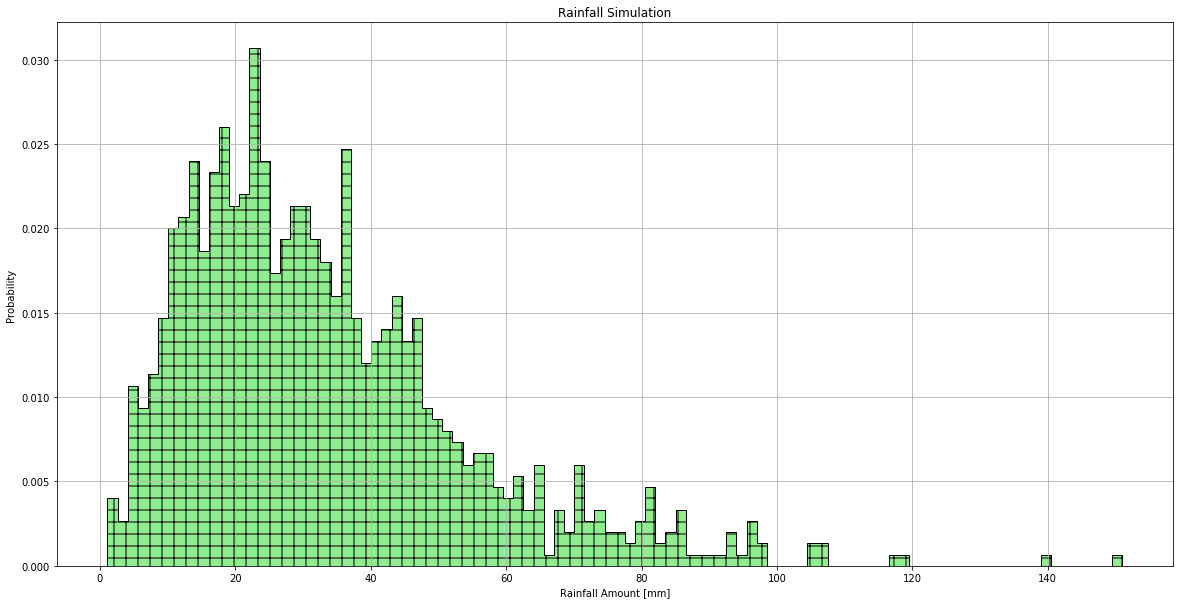

In [13]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-01-01', initialState = 0 , initialPrep =  0.4, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='lightgreen',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  7.683
The elapsed time over simulation is:  24.313215970993042  seconds.


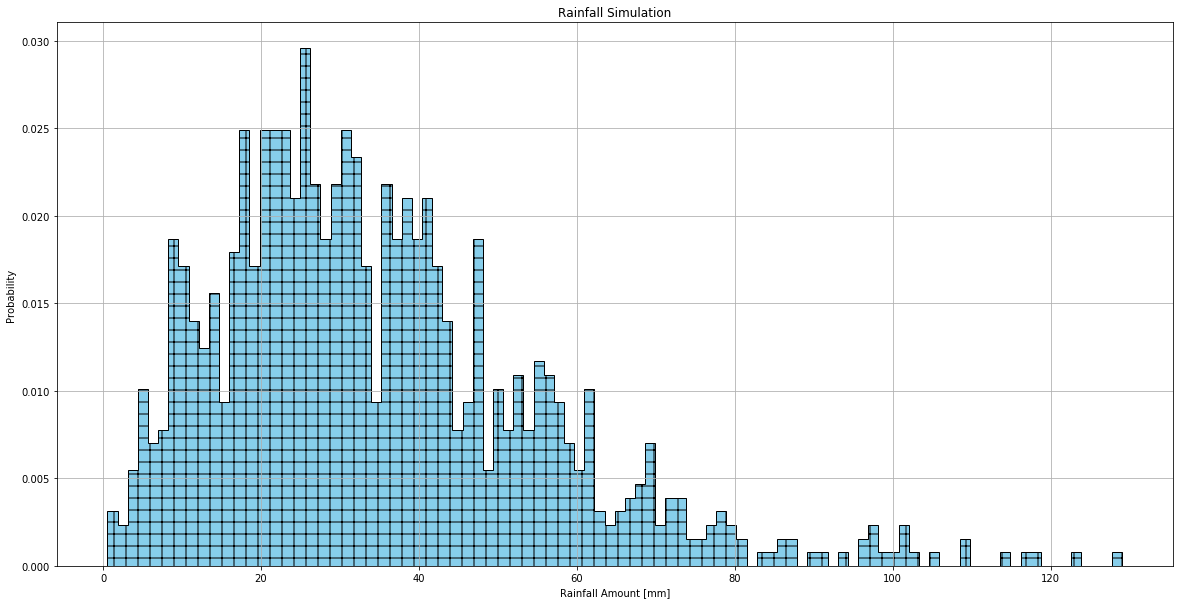

In [14]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-01-01', initialState = 1 , initialPrep =  0.4, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='skyblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  7.679
The elapsed time over simulation is:  29.333699703216553  seconds.


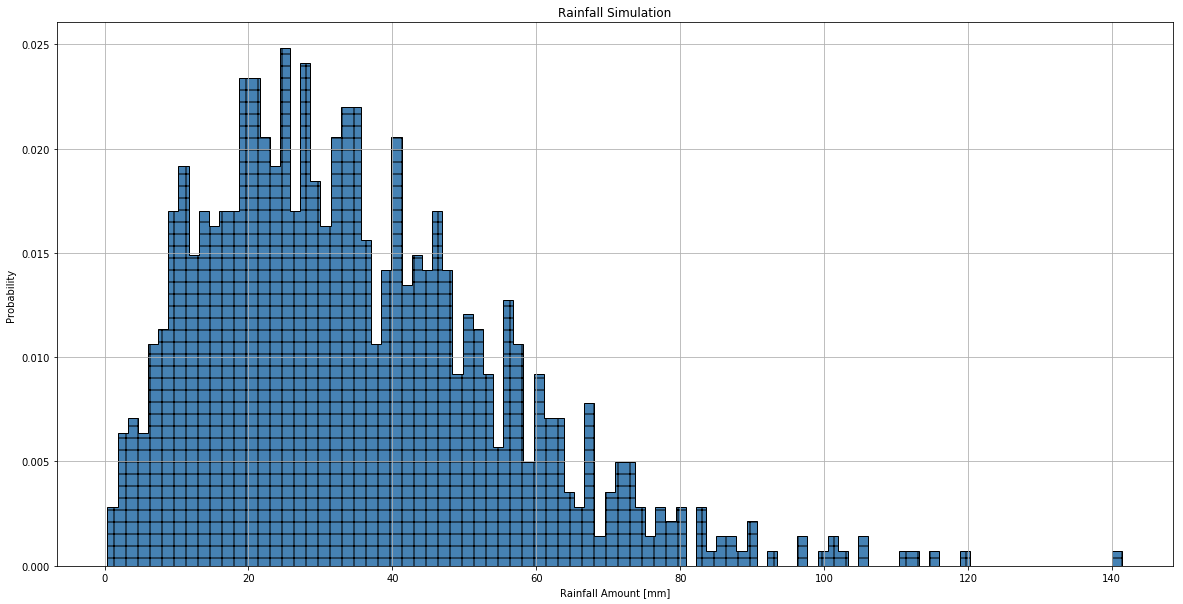

In [15]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-01-01', initialState = 1 , initialPrep =  5.0, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='steelblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

### Abril

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  25.626
The elapsed time over simulation is:  31.69754910469055  seconds.


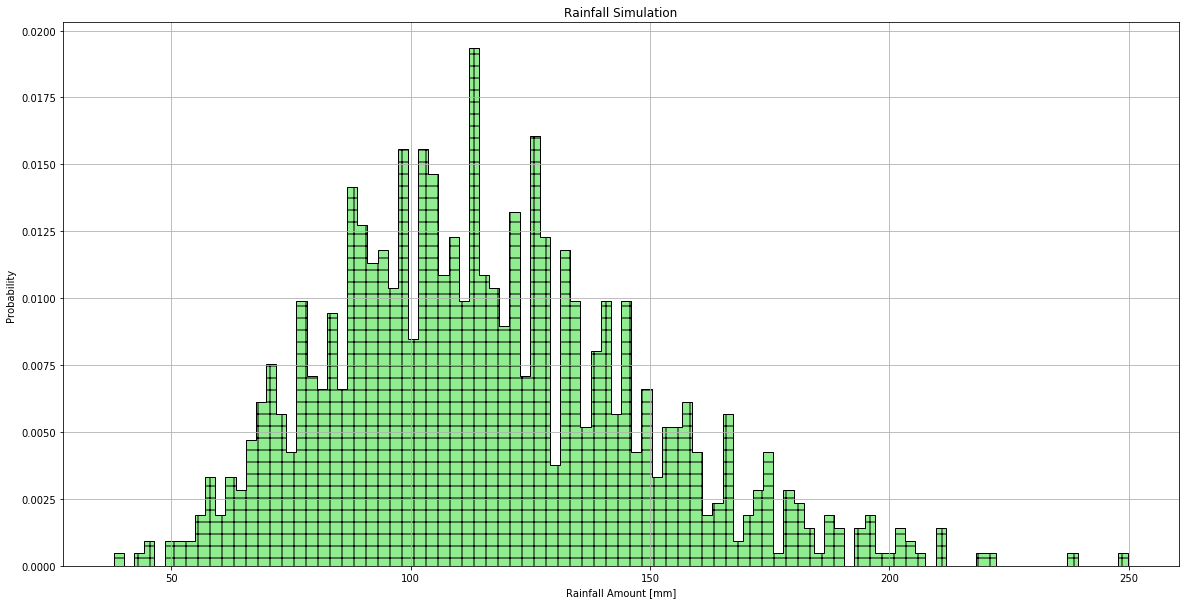

In [16]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-04-01', initialState = 0 , initialPrep =  0.4, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='lightgreen',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  25.431
The elapsed time over simulation is:  29.524255752563477  seconds.


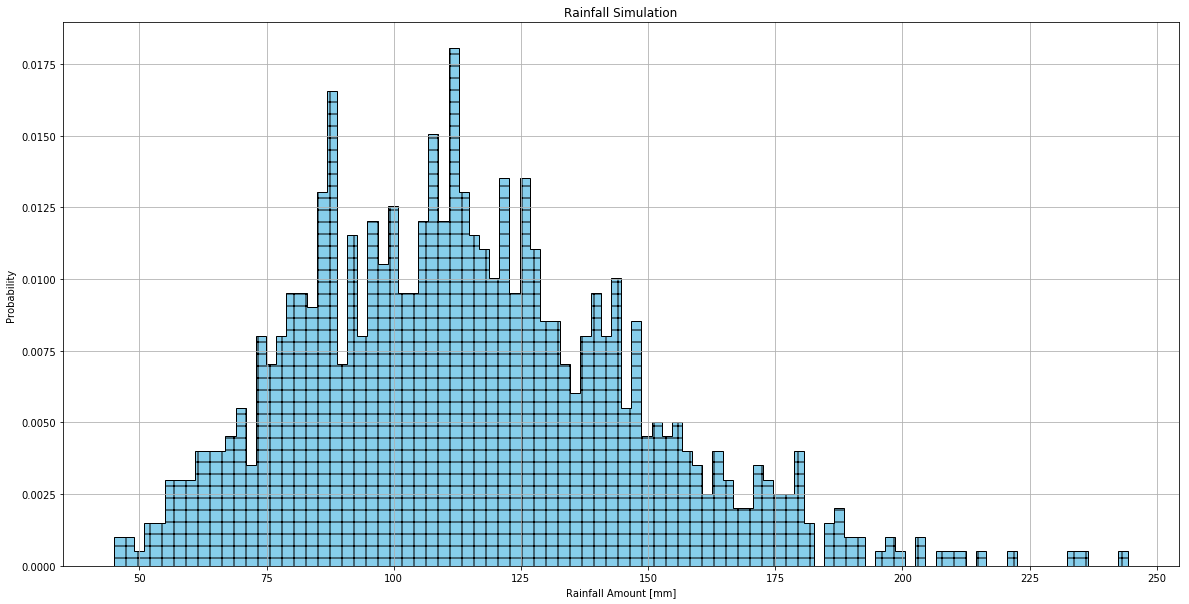

In [17]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-04-01', initialState = 1 , initialPrep =  0.4, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='skyblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  25.635
The elapsed time over simulation is:  28.105440139770508  seconds.


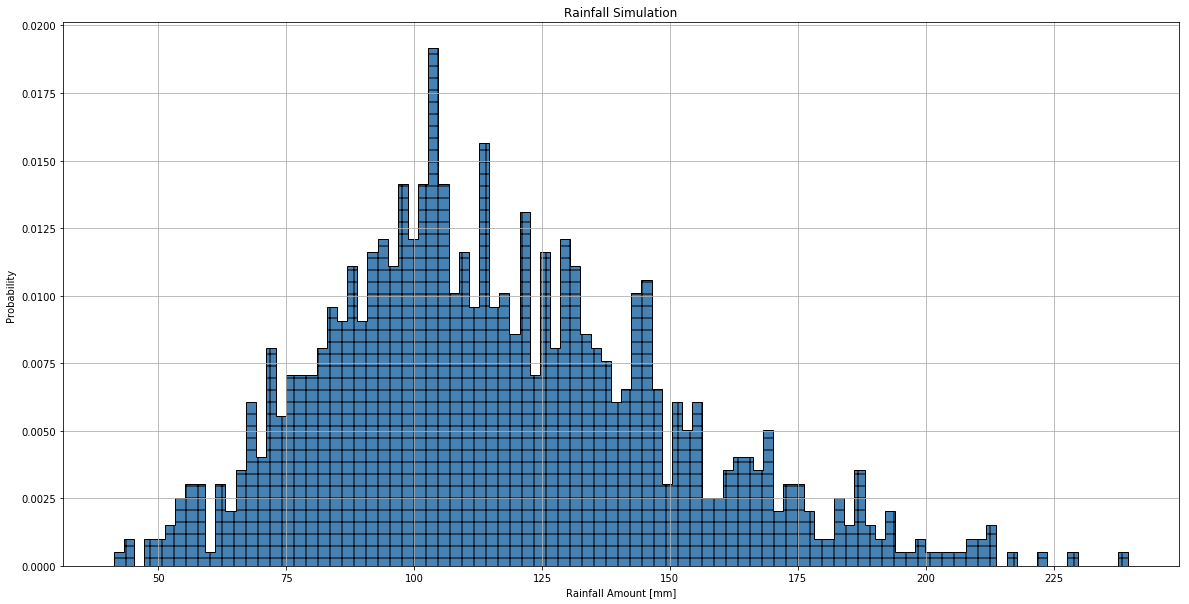

In [18]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-04-01', initialState = 1 , initialPrep =  5.0, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='steelblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

### Octubre

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  27.024
The elapsed time over simulation is:  28.84311008453369  seconds.


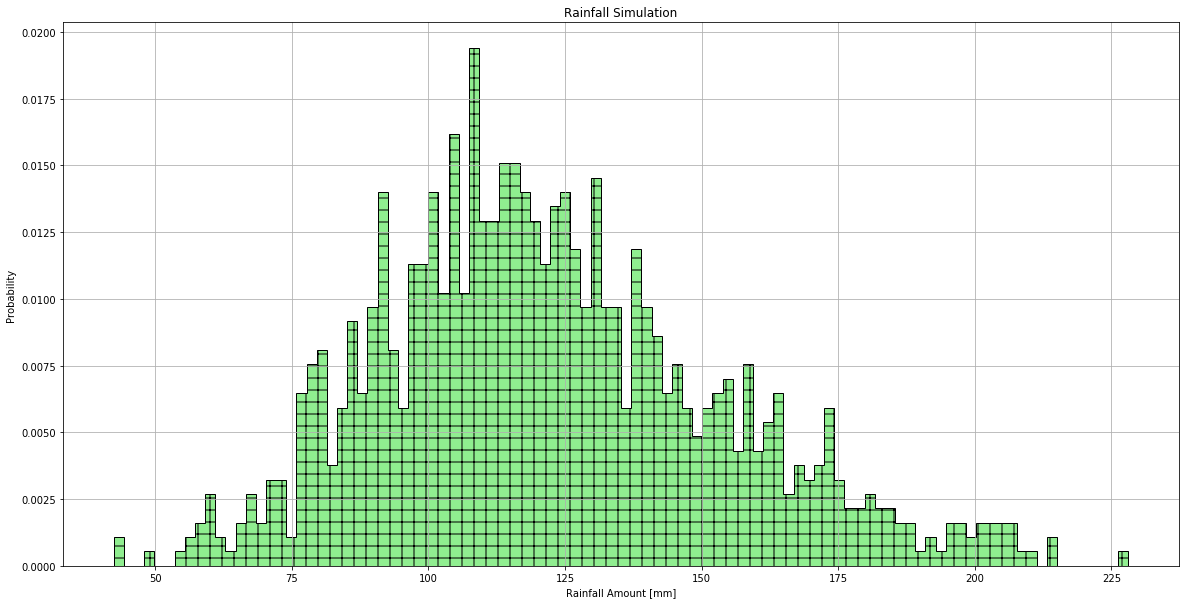

In [19]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-10-01', initialState = 0 , initialPrep =  0.4, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='lightgreen',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  27.052
The elapsed time over simulation is:  28.47736382484436  seconds.


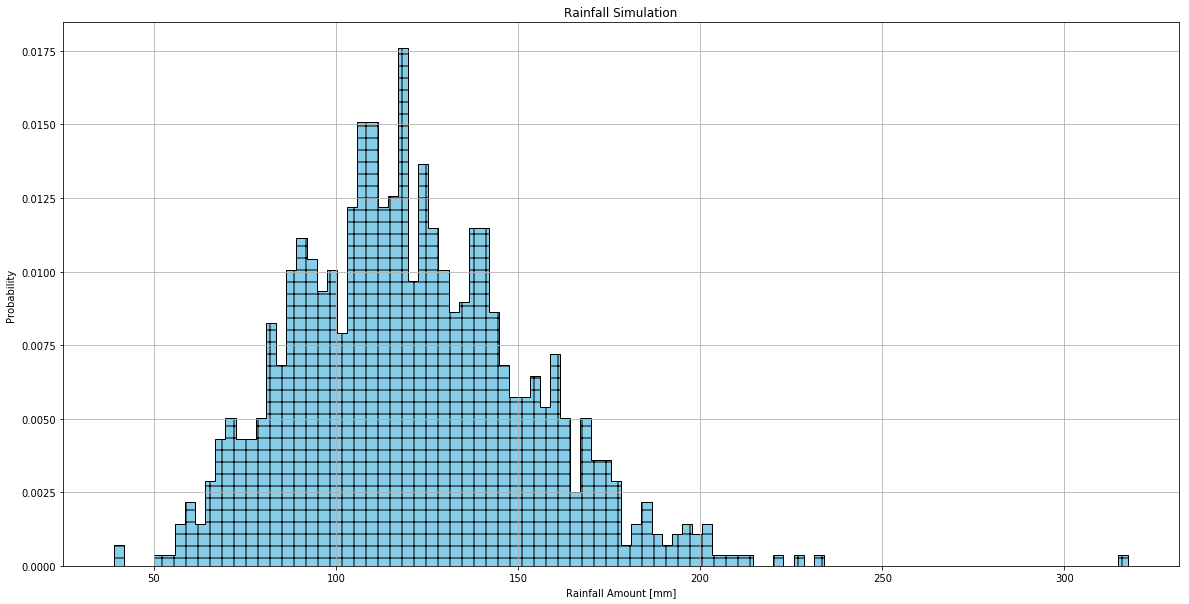

In [20]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-10-01', initialState = 1 , initialPrep =  0.4, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='skyblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  27.189
The elapsed time over simulation is:  28.558536052703857  seconds.


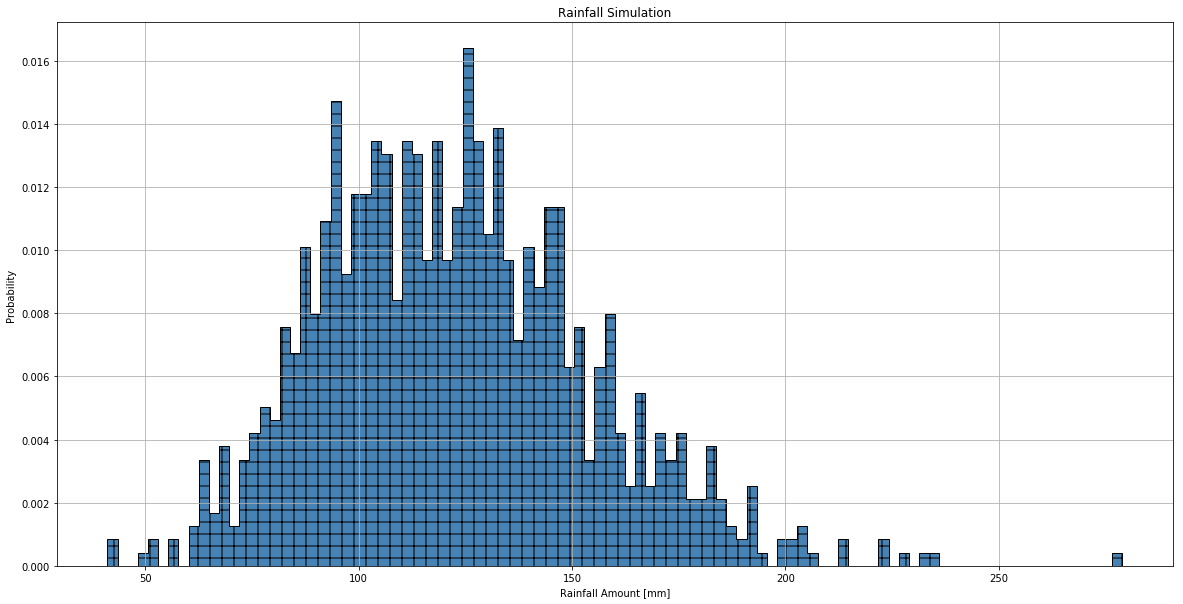

In [21]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2017-10-01', initialState = 1 , initialPrep =  5.0, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='steelblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

# Financial Analysis

In [22]:
def calculatePrice(strikePrice, interestRate, finalSimulationData):
    
    presentValueArray = [0]*len(finalSimulationData)
    
    for i in range(len(finalSimulationData)):
        tempDiff = finalSimulationData[i]-strikePrice
        
        realDiff = max(0,tempDiff)
        
        presentValue = realDiff*np.exp(-interestRate/12)
        
        presentValueArray[i] = presentValue 
    
    print('The option price should be: \n ' , np.mean(presentValueArray))

In [23]:
calculatePrice(50,0.20,finalSimulation)

The option price should be: 
  71.2428124433189


## Compare Data

In [24]:
import pickle 
path = '../datasets'
allDataDataframe = pickle.load(open(path+'/fullDataset/completeDailyDataset.pickle','rb'))

In [25]:
allDataDataframe.tail()

,Prep,Month,nino34,probNeutral,probNino,probNina,state,nextState
2015-12-26,0,12,2.43192,0,1,0,0,0
2015-12-27,0,12,2.44873,0,1,0,0,0
2015-12-28,0,12,2.395,0,1,0,0,0
2015-12-29,0,12,2.42051,0,1,0,0,0
2015-12-30,0,12,2.36802,0,1,0,0,0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


The mean of wet days is:  23.691
The elapsed time over simulation is:  27.514324426651  seconds.


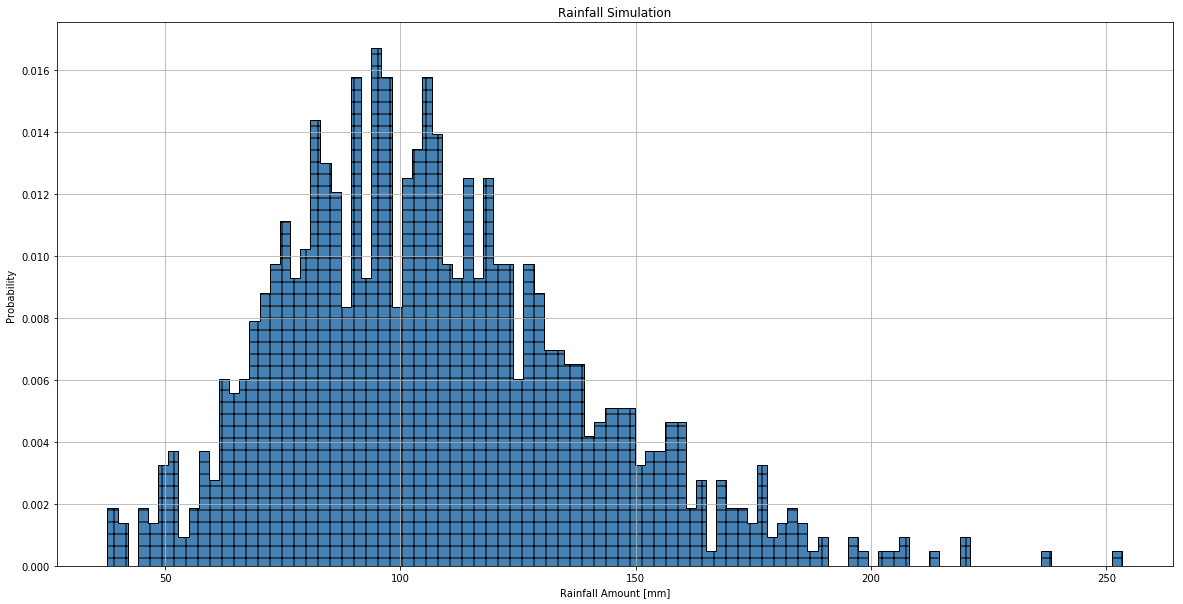

In [26]:
#### Define parameters simulation.

# Simulations iterations.
iterations = 1000

# Create dataframe to simulate. 
simulationDataFrame = createTotalDataFrame(daysNumber= 30, startDate = '2011-06-01', initialState = 1 , initialPrep =  10, ensoForecast = ensoForecast)

# Final Analysis.
finalSimulation = totalRun(simulationDataFrame, transitionsParametersDry, transitionsParametersWet, amountParametersGamma,iterations)

fig = plt.figure(figsize=(20, 10))

plt.hist(finalSimulation,facecolor='steelblue',bins=100, density=True,
         histtype='stepfilled', edgecolor = 'black' , hatch = '+')

plt.title('Rainfall Simulation')
plt.xlabel('Rainfall Amount [mm]')
plt.ylabel('Probability ')
plt.grid()
plt.show()

In [27]:
allDataDataframe['2011-06-01':'2011-06-30']['state'].sum()

19

In [28]:
allDataDataframe['2011-06-01':'2011-06-30']['Prep'].sum()

113.49999999999999

In [29]:
allDataDataframe.ix['2012-04-01']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


Prep                  0
Month                 4
nino34        -0.327419
probNeutral        0.88
probNino           0.02
probNina            0.1
state                 0
nextState             0
Name: 2012-04-01, dtype: object

In [30]:
allDataDataframe['2012-04-01':'2012-04-30']

,Prep,Month,nino34,probNeutral,probNino,probNina,state,nextState
2012-04-01,0,4,-0.327419,0.88,0.02,0.1,0,0
2012-04-02,0,4,-0.241092,0.88,0.02,0.1,0,0
2012-04-03,0,4,-0.138925,0.88,0.02,0.1,0,0
2012-04-04,0,4,-0.251277,0.88,0.02,0.1,0,0
2012-04-05,0,4,-0.325644,0.88,0.02,0.1,0,1
2012-04-06,6,4,-0.395549,0.88,0.02,0.1,1,1
2012-04-07,3.4,4,-0.492909,0.88,0.02,0.1,1,1
2012-04-08,8.6,4,-0.511054,0.88,0.02,0.1,1,1
2012-04-09,1.5,4,-0.434751,0.88,0.02,0.1,1,1
2012-04-10,56.8,4,-0.403892,0.88,0.02,0.1,1,1


In [31]:
bbbb = gamma.rvs(a = 5, scale = 3,size = 10000)
np.mean(bbbb)

14.966947167088778

In [32]:
np.var(bbbb)

44.324716707857455